In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.tri as mtri


In [2]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.05,186)
    return (signal+noise)

In [3]:
ptbdb_abnormal = pd.read_csv("ptbdb_abnormal.csv", header = None)
ptbdb_normal = pd.read_csv("ptbdb_normal.csv", header = None)

In [24]:
data = []

data.extend(ptbdb_normal.iloc[:, :186].values)
data.extend(ptbdb_abnormal.iloc[:, :186].values)

labels = []
labels.extend(ptbdb_normal.iloc[:, 187].values)
labels.extend(ptbdb_abnormal.iloc[:, 187].values)

data = np.array(data)
labels = np.array(labels)

print("Ukupno:")
print("U klasi abnormalnih  : ", len(ptbdb_abnormal))
print("U klasi normalnih    : ", len(ptbdb_normal))


Ukupno:
U klasi abnormalnih  :  10506
U klasi normalnih    :  4046


In [28]:
#Dataset skew, undersampling
#Izvrsiti ovu celiju ako se koristi undersampling


df_0_under = ptbdb_abnormal.sample(4046)
df_under = pd.concat([df_0_under, ptbdb_normal], axis=0)

equilibre=df_under[187].value_counts()
print("Ukupno:")
print("U klasi abnormalnih  : ", equilibre[0])
print("U klasi normalnih    : ", equilibre[1])

data = df_under.iloc[:, :186].values
labels = df_under.iloc[:, 187]

Ukupno:
U klasi abnormalnih  :  4046
U klasi normalnih    :  4046


In [42]:
#Dataset skew, oversampling
#Izvrsiti ovu celiju ako se koristi oversampling


#Oversampling
df_0_over = ptbdb_normal.sample(10506, replace = True)

df_over = pd.concat([ptbdb_abnormal, df_0_over], axis=0)

equilibre=df_over[187].value_counts()
print("Ukupno:")
print("U klasi abnormalnih  : ", equilibre[0])
print("U klasi normalnih    : ", equilibre[1])

data = df_under.iloc[:, :186].values
labels = df_under.iloc[:, 187]

Ukupno:
U klasi abnormalnih  :  10506
U klasi normalnih    :  10506


In [43]:
from keras.utils import to_categorical

one_hot_labels = np.zeros((len(labels), 2))
one_hot_labels[:] = to_categorical(labels[:], num_classes = 2)

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, one_hot_labels, test_size=0.33, random_state=42)

In [45]:
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, BatchNormalization, Dropout, Convolution1D, MaxPooling1D, SeparableConv1D, Flatten, MaxPool1D
from keras.optimizers import Adam
from keras.models import Model

In [46]:
X_train[:] = add_gaussian_noise(X_train[:])#Small data augmentation
X_test[:] = add_gaussian_noise(X_test[:])#Small data augmentation

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

im_shape=(X_train.shape[1],1)
inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
conv1_1=Convolution1D(128, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
conv1_1=BatchNormalization()(conv1_1)
pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
conv2_1=BatchNormalization()(conv2_1)
pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
conv3_1=BatchNormalization()(conv3_1)
pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
conv3_1=Convolution1D(32, (3), activation='relu', input_shape=im_shape)(pool2)
conv3_1=BatchNormalization()(conv3_1)
pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
flatten=Flatten()(pool3)
dense_end1 = Dense(64, activation='relu')(flatten)
dense_end2 = Dense(32, activation='relu')(dense_end1)
main_output = Dense(2, activation='softmax', name='main_output')(dense_end2)

In [47]:
model = Model(inputs= inputs_cnn, outputs=main_output)

In [48]:
model.compile(optimizer = Adam(lr = 100e-5), loss = "categorical_crossentropy", metrics = ["accuracy"])

In [55]:
EPOCHS = 5
history = model.fit(X_train, y_train, validation_split = 0.2, epochs = EPOCHS, shuffle = True, class_weight = 'auto')

Train on 4336 samples, validate on 1085 samples
Epoch 1/5
4336/4336 [==============================] - 8s 2ms/step - loss: 0.0419 - accuracy: 0.9843 - val_loss: 0.2064 - val_accuracy: 0.9567
Epoch 2/5
4336/4336 [==============================] - 8s 2ms/step - loss: 0.0366 - accuracy: 0.9869 - val_loss: 0.1680 - val_accuracy: 0.9530
Epoch 3/5
4336/4336 [==============================] - 8s 2ms/step - loss: 0.0346 - accuracy: 0.9880 - val_loss: 0.4632 - val_accuracy: 0.8793
Epoch 4/5
4336/4336 [==============================] - 8s 2ms/step - loss: 0.0268 - accuracy: 0.9910 - val_loss: 0.1521 - val_accuracy: 0.9576
Epoch 5/5
4336/4336 [==============================] - 8s 2ms/step - loss: 0.0174 - accuracy: 0.9940 - val_loss: 0.2127 - val_accuracy: 0.9512


In [56]:
print(model.evaluate(X_test, y_test))

2671/2671 [==============================] - 1s 488us/step
[0.2570136379142327, 0.9168850779533386]


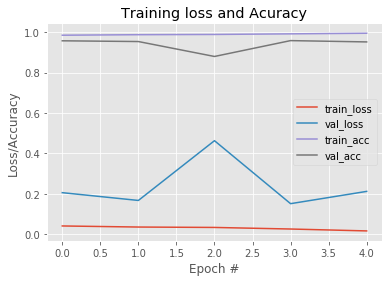

In [57]:
N = np.arange(0, EPOCHS)
title = "Training loss and Acuracy"

plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label = "train_loss")
plt.plot(N, history.history["val_loss"], label = "val_loss")
plt.plot(N, history.history["accuracy"], label = "train_acc")
plt.plot(N, history.history["val_accuracy"], label = "val_acc")
plt.title(title)
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [58]:
predictions = model.predict(X_test)
predictions = np.where(predictions < 0.5, 0, 1)

In [59]:
import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

accuracy = sklearn.metrics.accuracy_score(y_test, predictions)

print("Accuracy: {0:.2f}".format(100.0 * accuracy_score(y_test, predictions)))
print("Precision: {0:.2f}".format(100.0 * precision_score(y_test, predictions, average='micro')))
print("F1 score: {0:.2f}".format(100.0 * f1_score(y_test, predictions, average='micro')))

print('Classification Report:')
print(sklearn.metrics.classification_report(y_test, predictions))

Accuracy: 91.69
Precision: 91.69
F1 score: 91.69
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1340
           1       0.93      0.90      0.92      1331

   micro avg       0.92      0.92      0.92      2671
   macro avg       0.92      0.92      0.92      2671
weighted avg       0.92      0.92      0.92      2671
 samples avg       0.92      0.92      0.92      2671



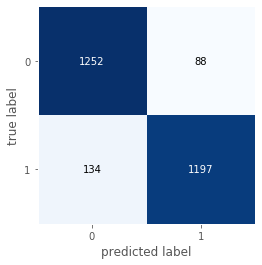

In [60]:
from mlxtend.evaluate import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

validation_numerical = np.argmax(y_test, axis = 1)
predictions_numerical = np.argmax(predictions, axis = 1)

cm = confusion_matrix(y_target=validation_numerical, 
                      y_predicted=predictions_numerical, 
                      binary=False)
cm
fig, ax = plot_confusion_matrix(cm)
plt.show()